In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =4.06197e-22

nband = 330

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 10

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6/

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

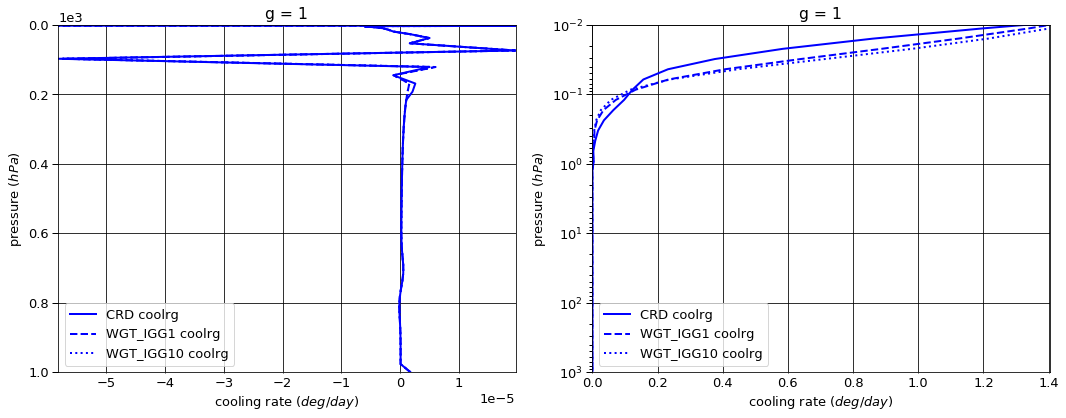

# Figure: cooling rate g-group 2

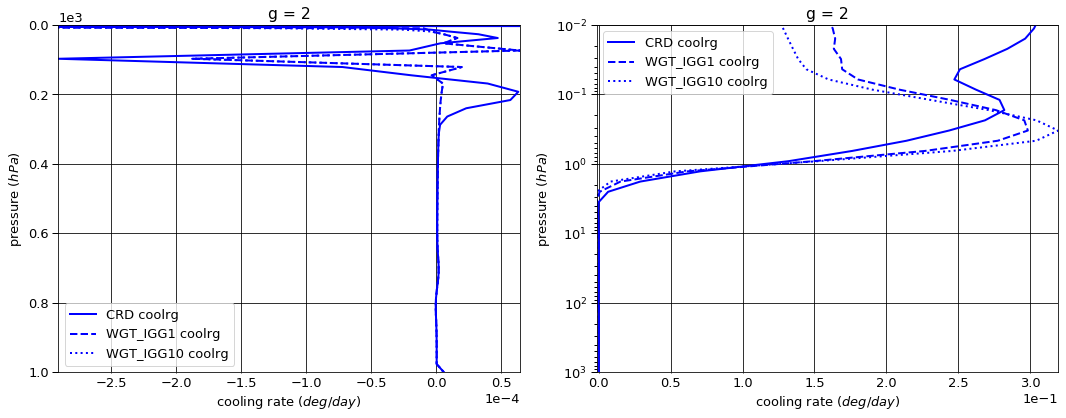

# Figure: cooling rate g-group 3

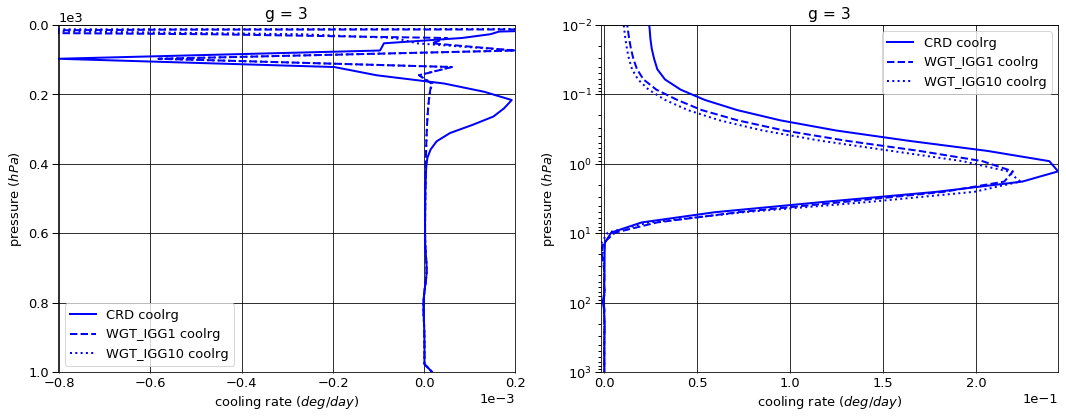

# Figure: cooling rate g-group 4

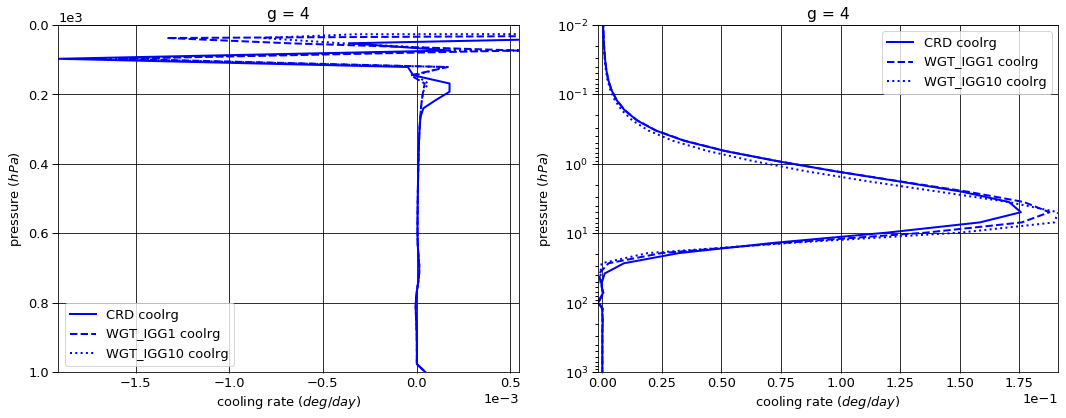

# Figure: cooling rate g-group 5

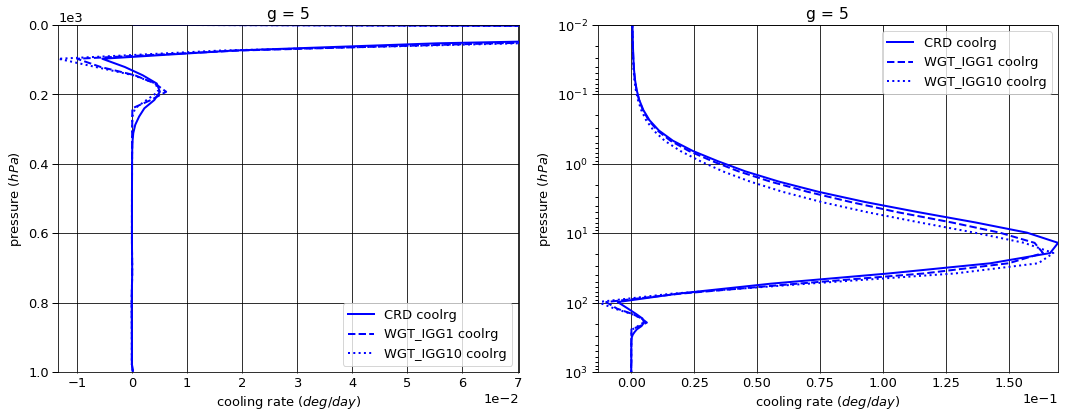

# Figure: cooling rate g-group 6

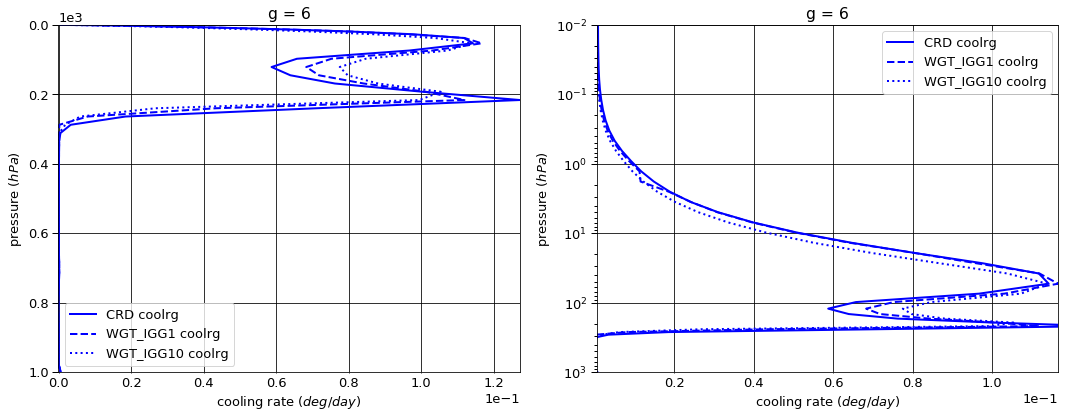

# Figure: cooling rate g-group 7

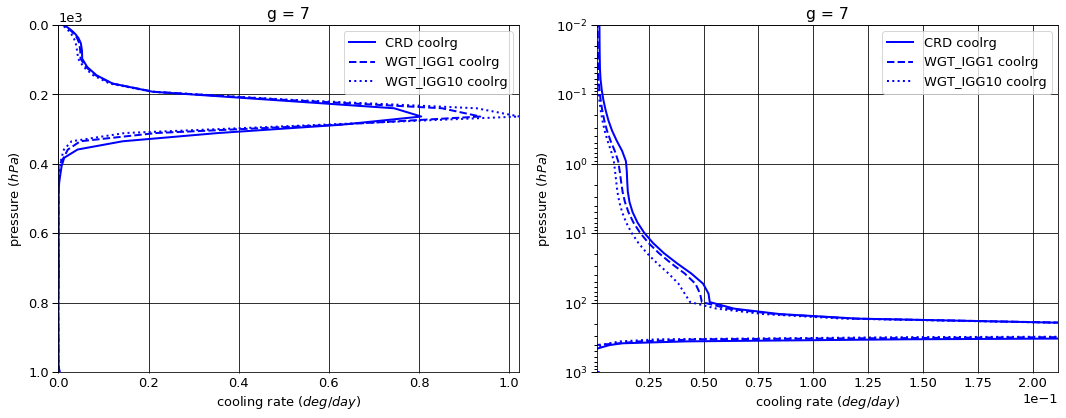

# Figure: cooling rate g-group 8

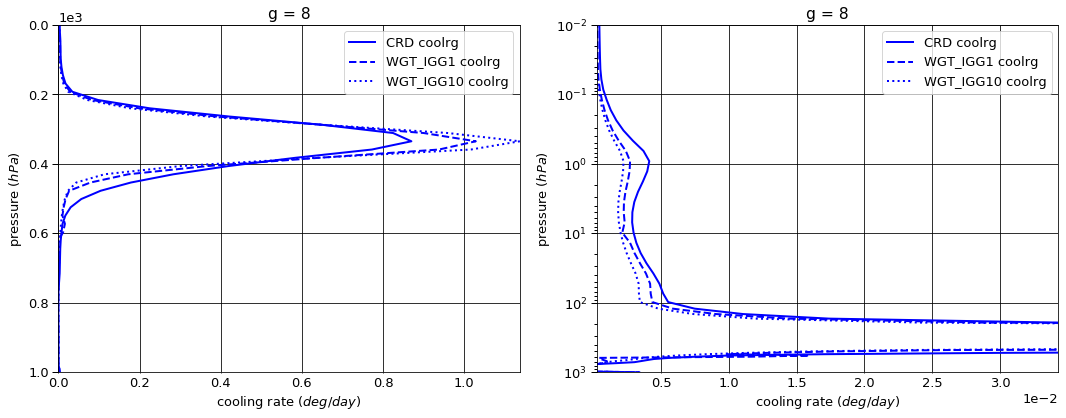

# Figure: cooling rate g-group 9

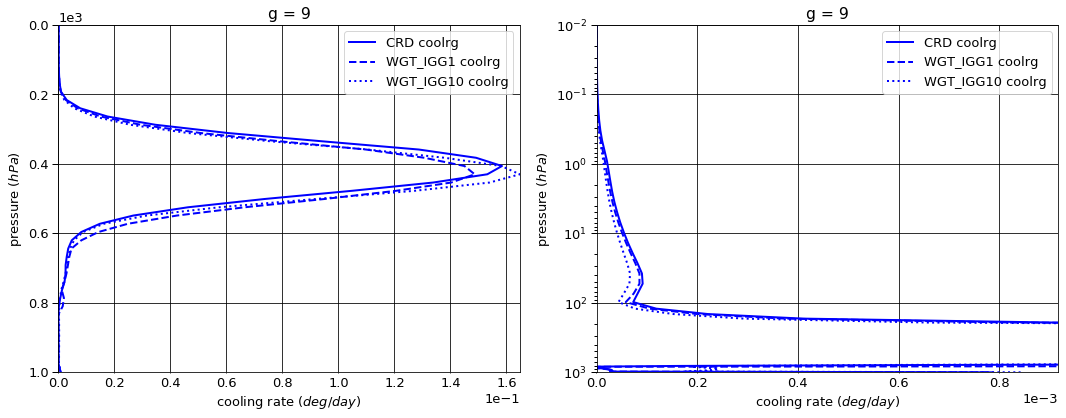

# Figure: cooling rate g-group total

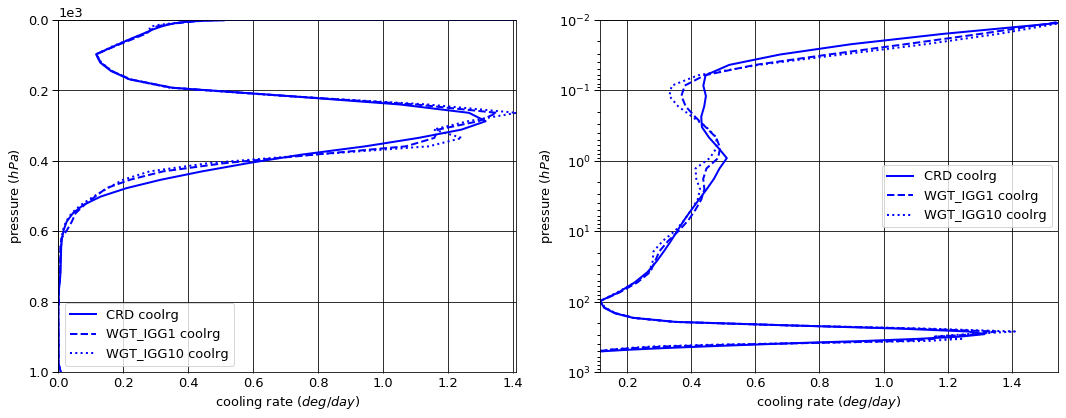

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007676   0.000000  -0.007676
  1013.0   76     -0.013241   0.013236  -0.000005
2 0.0      1      -0.031260   0.000000  -0.031260
  1013.0   76     -0.042959   0.042943  -0.000016
3 0.0      1      -0.102196   0.000000  -0.102196
  1013.0   76     -0.134174   0.134124  -0.000050
4 0.0      1      -0.254653   0.000000  -0.254653
  1013.0   76     -0.370903   0.370768  -0.000134
5 0.0      1      -0.888029   0.000000  -0.888029
  1013.0   76     -1.510122   1.509572  -0.000550
6 0.0      1      -2.585650   0.000000  -2.585650
  1013.0   76     -4.690264   4.688565  -0.001699
7 0.0      1     -11.013909   0.000000 -11.013909
  1013.0   76    -17.657991  17.651530  -0.006461
8 0.0      1     -15.973146   0.000000 -15.973146
  1013.0   76    -23.515960  23.506610  -0.009350
9 0.0      1      -3.490383   0.000000  -3.490383
  1013.0   76     -4.946278   4.944092  -0.002186


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007563   0.000000  -0.007563
  1013.0   76     -0.013241   0.013236  -0.000005
2 0.0      1      -0.031859   0.000000  -0.031859
  1013.0   76     -0.042960   0.042943  -0.000016
3 0.0      1      -0.102067   0.000000  -0.102067
  1013.0   76     -0.134174   0.134124  -0.000050
4 0.0      1      -0.256718   0.000000  -0.256718
  1013.0   76     -0.370903   0.370768  -0.000134
5 0.0      1      -0.883585   0.000000  -0.883585
  1013.0   76     -1.510122   1.509572  -0.000550
6 0.0      1      -2.547130   0.000000  -2.547130
  1013.0   76     -4.690264   4.688565  -0.001699
7 0.0      1     -10.931887   0.000000 -10.931887
  1013.0   76    -17.657991  17.651530  -0.006461
8 0.0      1     -15.857925   0.000000 -15.857925
  1013.0   76    -23.515960  23.506610  -0.009350
9 0.0      1      -3.533785   0.000000  -3.533785
  1013.0   76     -4.946278   4.944111  -0.002167


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007536   0.000000  -0.007536
  1013.0   76     -0.013241   0.013236  -0.000005
2 0.0      1      -0.031940   0.000000  -0.031940
  1013.0   76     -0.042960   0.042943  -0.000016
3 0.0      1      -0.102404   0.000000  -0.102404
  1013.0   76     -0.134174   0.134124  -0.000050
4 0.0      1      -0.256861   0.000000  -0.256861
  1013.0   76     -0.370903   0.370768  -0.000134
5 0.0      1      -0.884280   0.000000  -0.884280
  1013.0   76     -1.510122   1.509572  -0.000550
6 0.0      1      -2.525706   0.000000  -2.525706
  1013.0   76     -4.690264   4.688565  -0.001699
7 0.0      1     -10.934045   0.000000 -10.934045
  1013.0   76    -17.657991  17.651530  -0.006461
8 0.0      1     -15.850325   0.000000 -15.850325
  1013.0   76    -23.515960  23.506610  -0.009350
9 0.0      1      -3.529641   0.000000  -3.529641
  1013.0   76     -4.946278   4.944111  -0.002167


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1      1.126498e-04  0.000000e+00  1.126498e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1     -5.988730e-04  0.000000e+00 -5.988730e-04
  1013.0   76    -6.938894e-18  0.000000e+00  0.000000e+00
3 0.0      1      1.292100e-04  0.000000e+00  1.292100e-04
  1013.0   76     0.000000e+00  0.000000e+00 -6.776264e-21
4 0.0      1     -2.065250e-03  0.000000e+00 -2.065250e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5 0.0      1      4.444020e-03  0.000000e+00  4.444020e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6 0.0      1      3.852010e-02  0.000000e+00  3.852010e-02
  1013.0   76     8.881784e-16  0.000000e+00  0.000000e+00
7 0.0      1      8.202200e-02  0.000000e+00  8.202200e-02
  1013.0   76     0.000000e+00 -3.552714e-15  0.000000e+00
8 0.0      1      1.152210e-01  0.000000e+00  1.152210e-01
  1013.0   76     0.000000e+00 -3.552714e-15  4.040000e-08
9 0.0      1     -4.340150e-02  0.000000e+00 -4.340150e-02
  1013.0   76    -8.881784e-16  1.890000e-05  1.893200e-05


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1      1.394081e-04  0.000000e+00  1.394081e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1     -6.803490e-04  0.000000e+00 -6.803490e-04
  1013.0   76    -6.938894e-18  0.000000e+00  0.000000e+00
3 0.0      1     -2.079200e-04  0.000000e+00 -2.079200e-04
  1013.0   76     0.000000e+00  0.000000e+00 -6.776264e-21
4 0.0      1     -2.207930e-03  0.000000e+00 -2.207930e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5 0.0      1      3.748600e-03  0.000000e+00  3.748600e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6 0.0      1      5.994390e-02  0.000000e+00  5.994390e-02
  1013.0   76     8.881784e-16  0.000000e+00  0.000000e+00
7 0.0      1      7.986400e-02  0.000000e+00  7.986400e-02
  1013.0   76     0.000000e+00 -3.552714e-15  0.000000e+00
8 0.0      1      1.228210e-01  0.000000e+00  1.228210e-01
  1013.0   76     0.000000e+00 -3.552714e-15  4.040000e-08
9 0.0      1     -3.925780e-02  0.000000e+00 -3.925780e-02
  1013.0   76    -8.881784e-16  1.890000e-05  1.893160e-05

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      3.956974e+00
  1001.112500 75     1.756907e-06
2 0.000312    1      2.804517e-01
  1001.112500 75     5.795832e-06
3 0.000312    1      1.935491e-02
  1001.112500 75     1.786929e-05
4 0.000312    1      9.902119e-06
  1001.112500 75     4.838762e-05
5 0.000312    1      2.953600e-04
  1001.112500 75     1.981060e-04
6 0.000312    1      6.436535e-04
  1001.112500 75     6.117722e-04
7 0.000312    1      2.165413e-03
  1001.112500 75     2.326758e-03
8 0.000312    1      3.261394e-04
  1001.112500 75     3.366270e-03
9 0.000312    1      6.046344e-07
  1001.112500 75     7.874050e-04


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.154933e+00
  1001.112500 75     1.756907e-06
2 0.000312    1      1.351087e-01
  1001.112500 75     5.795832e-06
3 0.000312    1      9.245889e-03
  1001.112500 75     1.786929e-05
4 0.000312    1      1.003387e-05
  1001.112500 75     4.838762e-05
5 0.000312    1      2.592019e-04
  1001.112500 75     1.981060e-04
6 0.000312    1      3.779444e-04
  1001.112500 75     6.117722e-04
7 0.000312    1      1.516179e-03
  1001.112500 75     2.326758e-03
8 0.000312    1      2.113862e-04
  1001.112500 75     3.366255e-03
9 0.000312    1      3.492331e-07
  1001.112500 75     7.801012e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.815395e+00
  1001.112500 75     1.756907e-06
2 0.000312    1      1.026519e-01
  1001.112500 75     5.795832e-06
3 0.000312    1      7.846943e-03
  1001.112500 75     1.786929e-05
4 0.000312    1      8.778854e-06
  1001.112500 75     4.838762e-05
5 0.000312    1      2.258549e-04
  1001.112500 75     1.981060e-04
6 0.000312    1      3.206296e-04
  1001.112500 75     6.117722e-04
7 0.000312    1      1.220624e-03
  1001.112500 75     2.326758e-03
8 0.000312    1      1.677116e-04
  1001.112500 75     3.366255e-03
9 0.000312    1      2.681660e-07
  1001.112500 75     8.490010e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.802042e+00
  1001.112500 75    -2.117582e-22
2 0.000312    1     -1.453430e-01
  1001.112500 75     8.470329e-22
3 0.000312    1     -1.010902e-02
  1001.112500 75     0.000000e+00
4 0.000312    1      1.317515e-07
  1001.112500 75     0.000000e+00
5 0.000312    1     -3.615817e-05
  1001.112500 75     0.000000e+00
6 0.000312    1     -2.657091e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -6.492334e-04
  1001.112500 75     0.000000e+00
8 0.000312    1     -1.147532e-04
  1001.112500 75    -1.520000e-08
9 0.000312    1     -2.554014e-07
  1001.112500 75    -7.303850e-06


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.141579e+00
  1001.112500 75    -2.117582e-22
2 0.000312    1     -1.777998e-01
  1001.112500 75     8.470329e-22
3 0.000312    1     -1.150797e-02
  1001.112500 75     0.000000e+00
4 0.000312    1     -1.123264e-06
  1001.112500 75     0.000000e+00
5 0.000312    1     -6.950516e-05
  1001.112500 75     0.000000e+00
6 0.000312    1     -3.230239e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -9.447892e-04
  1001.112500 75     0.000000e+00
8 0.000312    1     -1.584279e-04
  1001.112500 75    -1.520000e-08
9 0.000312    1     -3.364684e-07
  1001.112500 75     6.159596e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.346902,0.000000,-34.346902
1013.0,76,-52.881893,52.861441,-0.020451



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.152519,0.00000,-34.152519
1013.0,76,-52.881893,52.86146,-0.020432



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.122739,0.00000,-34.122739
1013.0,76,-52.881893,52.86146,-0.020432



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.943834e-01,0.000000,0.194383
1013.0,76,-7.105427e-15,0.000019,0.000019



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.241629e-01,0.000000,0.224163
1013.0,76,-7.105427e-15,0.000019,0.000019


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,4.260222
1001.112500,75,0.007364



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.301662
1001.112500,75,0.007357



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,1.927838
1001.112500,75,0.007426



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.958560
1001.112500,75,-0.000007



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.332384
1001.112500,75,0.000062


In [20]:
table_dgdgs.display_dgdgs(crd)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000303,0.000255
2,0.000848,0.000821
3,0.002758,0.002575
4,0.008303,0.007168
5,0.033167,0.029129
6,0.105697,0.090655
7,0.381500,0.340109
8,0.380864,0.440102
9,0.086561,0.089186


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.222796e-17
2,5.686282e-18
3,4.476633e-19
4,1.008726e-18
5,8.035412e-20
6,6.291501e-20
7,5.056287e-21
8,4.063584e-22
9,1.792420e-23


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.222796e-17,NaN,0.000303,0.000255,0.000303,0.000255,1.0
2,5.686282e-18,0.078727,0.000848,0.000821,0.001152,0.001075,1.0
3,4.476633e-19,0.078727,0.002758,0.002575,0.003909,0.003650,1.0
4,1.008726e-18,2.253314,0.008303,0.007168,0.012212,0.010818,30.0
5,8.035412e-20,0.079659,0.033167,0.029129,0.045379,0.039947,30.0
6,6.291501e-20,0.782972,0.105697,0.090655,0.151076,0.130602,300.0
7,5.056287e-21,0.080367,0.381500,0.340109,0.532576,0.470711,300.0
8,4.063584e-22,0.080367,0.380864,0.440102,0.913439,0.910814,300.0
9,1.792420e-23,0.044109,0.086561,0.089186,1.000000,1.000000,300.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     3.387406e-16  1.080884e-16   3.133921  1.226689e-02
      2 0.000312     8.630306e-18  3.255763e-18   2.650778  3.368423e-04
      3 0.000312     2.469640e-19  6.959963e-20   3.548352  8.497571e-06
      4 0.000312     3.876963e-23  3.876887e-23   1.000020  2.682567e-09
      5 0.000312     2.598179e-22  1.661408e-22   1.563842  1.344040e-08
      6 0.000312     1.531091e-22  4.925573e-23   3.108452  5.563964e-09
      7 0.000312     1.522954e-22  1.428741e-23  10.659407  6.718141e-09
      8 0.000312     2.191473e-23  1.118864e-24  19.586585  9.407805e-10
      9 0.000312     2.404597e-25  4.081383e-26   5.891623  1.111256e-11
2     1 0.000750     3.393418e-16  1.083492e-16   3.131926  4.951056e-03
      2 0.000750     8.684179e-18  3.271137e-18   2.654789  1.364260e-04
      3 0.000750     2.483275e-19  7.041968e-20   3.526393  3.450108e-06
      4 0.000750     9.216585e-23  9.216251e-23   1.000036  2.568615e-09
      5 0.000750     2.660402e-22  1.717643e-22   1.548868  5.575351e-09
      6 0.000750     1.535548e-22  4.975408e-23   3.086276  2.254540e-09
      7 0.000750     1.527433e-22  1.437412e-23  10.626275  2.714435e-09
      8 0.000750     2.206581e-23  1.126981e-24  19.579573  3.815506e-10
      9 0.000750     2.430590e-25  4.139769e-26   5.871319  4.525966e-12
3     1 0.001052     3.405499e-16  1.087757e-16   3.130754  6.969122e-03
      2 0.001052     8.788447e-18  3.293557e-18   2.668376  1.931578e-04
      3 0.001052     2.504418e-19  7.132112e-20   3.511468  4.887835e-06
      4 0.001052     1.290593e-22  1.290530e-22   1.000049  5.044078e-09
      5 0.001052     2.725003e-22  1.770305e-22   1.539285  8.038618e-09
      6 0.001052     1.540476e-22  5.031871e-23   3.061437  3.182960e-09
      7 0.001052     1.536054e-22  1.448974e-23  10.600982  3.828710e-09
      8 0.001052     2.237012e-23  1.137983e-24  19.657693  5.423896e-10
      9 0.001052     2.478806e-25  4.203661e-26   5.896780  6.470209e-12
4     1 0.001476     3.417714e-16  1.092281e-16   3.128971  9.814384e-03
      2 0.001476     8.896173e-18  3.317980e-18   2.681201  2.736890e-04
      3 0.001476     2.527485e-19  7.238818e-20   3.491571  6.936005e-06
      4 0.001476     1.808267e-22  1.808146e-22   1.000067  9.914571e-09
      5 0.001476     2.803771e-22  1.836352e-22   1.526816  1.166039e-08
      6 0.001476     1.546374e-22  5.098582e-23   3.032949  4.500656e-09
      7 0.001476     1.545068e-22  1.461919e-23  10.568767  5.403758e-09
      8 0.001476     2.268458e-23  1.150266e-24  19.721159  7.715287e-10
      9 0.001476     2.529489e-25  4.280385e-26   5.909490  9.260574e-12
5     1 0.002070     3.429902e-16  1.097095e-16   3.126349  1.381956e-02
      2 0.002070     9.006431e-18  3.344884e-18   2.692599  3.878648e-04
      3 0.002070     2.552800e-19  7.367745e-20   3.464832  9.856163e-06
      4 0.002070     2.534676e-22  2.534441e-22   1.000093  1.949197e-08
      5 0.002070     2.901528e-22  1.920685e-22   1.510674  1.703425e-08
      6 0.002070     1.553557e-22  5.178864e-23   2.999803  6.372354e-09
      7 0.002070     1.554411e-22  1.476629e-23  10.526756  7.626880e-09
      8 0.002070     2.300560e-23  1.164174e-24  19.761305  1.097377e-09
      9 0.002070     2.582461e-25  4.374296e-26   5.903718  1.326208e-11
6     1 0.002904     3.442061e-16  1.102313e-16   3.122582  1.946398e-02
      2 0.002904     9.119835e-18  3.375272e-18   2.701955  5.500376e-04
      3 0.002904     2.581146e-19  7.527749e-20   3.428842  1.403818e-05
      4 0.002904     3.553982e-22  3.553524e-22   1.000129  3.833664e-08
      5 0.002904     3.025643e-22  2.030573e-22   1.490044  2.512609e-08
      6 0.002904     1.562518e-22  5.278001e-23   2.960436  9.042606e-09
      7 0.002904     1.564154e-22  1.493799e-23  10.470981  1.076898e-08
      8 0.002904     2.333379e-23  1.180339e-24  19.768711  1.561273e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
